In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import zipfile
import io

from google.colab import files
uploaded = files.upload()

# Get uploaded file name (it will be your .zip file)
zip_file = list(uploaded.keys())[0]

# Open the zip file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file]), 'r') as z:
    # Show files inside the zip
    print("Files inside zip:", z.namelist())

    # Extract and read the first CSV file
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f, encoding='latin1')  # latin1 avoids utf-8 error

# Preview the dataset
df.head()


In [ ]:
df.head()
df.info()
df.describe()


In [ ]:
df.isnull().sum()     # check missing values
df.dropna(inplace=True)   # drop missing rows (or fill them with mean/median)
df.drop_duplicates(inplace=True)  # remove duplicates


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of each sentiment
sns.countplot(x='sentiment', data=df)
plt.title("sentiment distributions")
plt.show()


In [2]:
from google.colab import files
import io, zipfile
import pandas as pd

uploaded = files.upload()
fname = next(iter(uploaded))

if fname.endswith(".csv"):
    df = pd.read_csv(io.BytesIO(uploaded[fname]), encoding="utf-8")
elif fname.endswith(".xlsx"):
    df = pd.read_excel(io.BytesIO(uploaded[fname]))
elif fname.endswith(".zip"):
    z = zipfile.ZipFile(io.BytesIO(uploaded[fname]))
    csv_files = [f for f in z.namelist() if f.endswith(".csv")]
    with z.open(csv_files[0]) as f:
        df = pd.read_csv(f, encoding="utf-8")

print("Shape:", df.shape)
df.head()

Saving IMDB Dataset.csv.zip to IMDB Dataset.csv (1).zip
Shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# drop rows with no rating or no title
# df = df.dropna(subset=['rating']) # This column does not exist
# if 'title' in df.columns: # This column does not exist
#     df = df.dropna(subset=['title']) # This column does not exist

# fill genres missing
if 'genres' in df.columns:
    df['genres'] = df['genres'].fillna('Unknown')

# drop exact duplicate rows
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped {before-after} duplicate rows.")

Dropped 418 duplicate rows.


In [6]:
# ensure rating numeric
# df['rating'] = pd.to_numeric(df['rating'], errors='coerce') # This column does not exist
# df = df.dropna(subset=['rating']) # This column does not exist

# convert timestamp if exists (MovieLens stores as unix seconds)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

In [9]:
# print("Rating summary:")
# print(df['rating'].describe())
# print("Median:", df['rating'].median(), "Mode:", df['rating'].mode().iloc[0])

# histogram + KDE
# plt.figure(figsize=(8,4))
# sns.histplot(df['rating'], bins=20, kde=True)
# plt.title('Ratings distribution')
# plt.xlabel('Rating')
# plt.show()

In [10]:
# If genres column is pipe-separated (e.g., "Action|Comedy"), split & explode
if 'genres' in df.columns:
    df['genres_list'] = df['genres'].astype(str).str.split('|')
    exploded = df.explode('genres_list').rename(columns={'genres_list':'genre'})
    exploded['genre'] = exploded['genre'].str.strip()
else:
    exploded = df.copy()
    exploded['genre'] = 'Unknown'

exploded.head()


,review,sentiment,genre
0,One of the other reviewers has mentioned that ...,positive,Unknown
1,A wonderful little production. <br /><br />The...,positive,Unknown
2,I thought this was a wonderful way to spend ti...,positive,Unknown
3,Basically there's a family where a little boy ...,negative,Unknown
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Unknown


In [12]:
# counts per genre
genre_counts = exploded['genre'].value_counts().rename_axis('genre').reset_index(name='counts')
# average rating and count per genre
# genre_stats = exploded.groupby('genre')['rating'].agg(count='count', mean='mean', median='median', std='std').reset_index()
# genre_stats = genre_stats.sort_values('count', ascending=False)
# genre_stats.head(15)

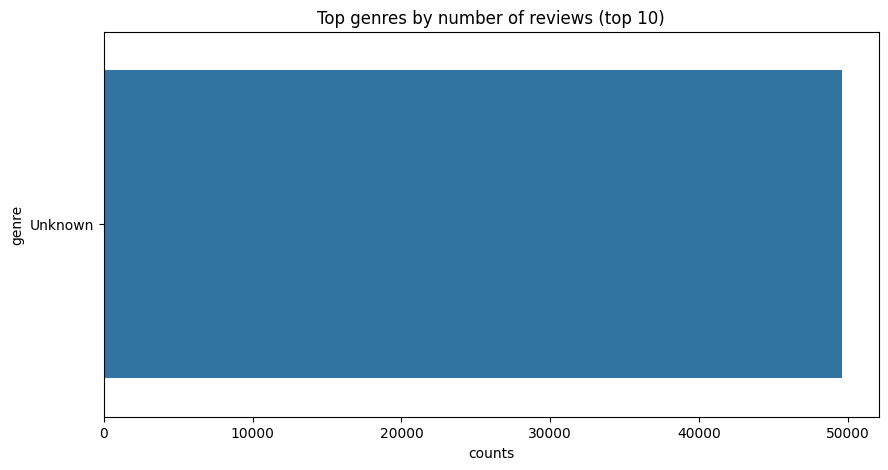

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 10
# top_genres = genre_stats.head(top_n)['genre'].tolist() # genre_stats is not defined

plt.figure(figsize=(10,5))
sns.barplot(data=genre_counts.head(top_n), x='counts', y='genre') # Use genre_counts instead of genre_stats
plt.title('Top genres by number of reviews (top 10)') # Updated title
plt.show()

# plt.figure(figsize=(10,5)) # This plot requires rating data which is not available
# sns.barplot(data=genre_stats.query("count >= 50").sort_values('mean', ascending=False).head(top_n), x='mean', y='genre')
# plt.title('Top genres by average rating (min 50 votes)')
# plt.xlabel('Average rating')
# plt.show()

In [17]:
# movie_stats = df.groupby(['movieId','title'])['rating'].agg(count='count', mean='mean').reset_index()
# top_movies = movie_stats.query('count >= 50').sort_values('mean', ascending=False).head(20)
# top_movies

In [18]:
if 'timestamp' in df.columns and df['timestamp'].notna().any():
    ts = df.set_index('timestamp').resample('M')['rating'].mean().dropna()
    plt.figure(figsize=(12,4))
    ts.plot()
    plt.title('Average rating over time (monthly)')
    plt.ylabel('Average rating')
    plt.show()

    # per-genre time trend for top 5 genres
    top5 = genre_stats.head(5)['genre'].tolist()
    exploded['month'] = exploded['timestamp'].dt.to_period('M')
    monthly = exploded[exploded['genre'].isin(top5)].groupby(['month','genre'])['rating'].mean().reset_index()
    monthly['month'] = monthly['month'].dt.to_timestamp()
    plt.figure(figsize=(12,6))
    sns.lineplot(data=monthly, x='month', y='rating', hue='genre')
    plt.title('Monthly average rating per genre (top 5 genres)')
    plt.show()


In [25]:
# Boxplot of ratings for top N genres
# plt.figure(figsize=(12,6))
# sns.boxplot(data=exploded[exploded['genre'].isin(top_genres)], x='genre', y='rating')
# plt.xticks(rotation=45)
# plt.title('Rating distribution by genre (top genres)')
# plt.show()

# Optional: heatmap of mean rating for top genres vs. top years (if year available)
# if 'timestamp' in df.columns:
#     exploded['year'] = exploded['timestamp'].dt.year
#     pivot = exploded[exploded['genre'].isin(top_genres)].pivot_table(index='genre', columns='year', values='rating', aggfunc='mean')
#     plt.figure(figsize=(12,6))
#     sns.heatmap(pivot, annot=False)
#     plt.title('Mean rating: genre vs. year (top genres)')
#     plt.show()

In [23]:
# genre_stats.to_csv('genre_stats.csv', index=False) # genre_stats is not defined
# movie_stats.to_csv('movie_stats.csv', index=False) # movie_stats is not defined
# save a figure example
plt.figure(figsize=(8,4))
# sns.histplot(df['rating'], bins=20) # 'rating' column does not exist
plt.savefig('ratings_distribution.png', bbox_inches='tight')

<Figure size 800x400 with 0 Axes>